In [183]:
import numpy as np
import optuna
import torch
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset
from darts.metrics import smape
from darts.models import TCNModel
from darts.utils.likelihood_models import GaussianLikelihood

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.datasets import WeatherDataset
from darts.models import LinearRegressionModel
import darts.metrics as metrics
from darts.datasets import AirPassengersDataset
import datetime

import numpy as np
import optuna
import torch
from optuna.integration import PyTorchLightningPruningCallback
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

from darts.dataprocessing.transformers import Scaler
from darts.datasets import AirPassengersDataset
from darts.models import AutoARIMA
from darts.utils.likelihood_models import GaussianLikelihood
from optuna.terminator import report_cross_validation_scores

from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from darts import TimeSeries

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold


In [184]:
import os
import sys
src_path = sys.path[0].replace("paper_working", "src")
# data_path = sys.path[0].replace("notebooks", "data")
if src_path not in sys.path:
    sys.path.append(src_path)

out_path = sys.path[0].replace("paper_working", "output")

import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

rc_={
    "figure.dpi":300,
    "font.size":10,
    #"axes.facecolor":"white",
    #"savefig.facecolor":"white",
    "text.usetex":False,
    "legend.frameon":False
}
plt.rcParams.update(rc_)


#from plot_helper import *

#from utils.plot_utils import *
#customize_plt() # customize plt configs, see plot_utils

In [185]:
metrics_method_dic={
    'CV':metrics.coefficient_of_variation,
    'MAE':metrics.mae,
    'MAPE':metrics.mape,
    'OPE':metrics.ope,
    'RMSE':metrics.rmse,
    'MSE':metrics.mse,
    'MARRE':metrics.marre,
    #'MASE':metrics.mase,
    'R2':metrics.r2_score,
    'SMAPE':metrics.smape,
}

In [186]:
def cal_metrics(pred_values,real_values):
    metrics_method_dic={
        'CV':metrics.coefficient_of_variation,
        'MAE':metrics.mae,
        'MAPE':metrics.mape,
        'OPE':metrics.ope,
        'RMSE':metrics.rmse,
        'MSE':metrics.mse,
        'MARRE':metrics.marre,
        #'MASE':metrics.mase,
        'R2':metrics.r2_score,
        'SMAPE':metrics.smape,
    }
    metrics_dic={
        'start_time':real_values.time_index[0],
        'end_time':real_values.time_index[-1],
        'n':len(real_values.time_index),
    }
    
    for metric in metrics_method_dic.keys():
        try:
            value=metrics_method_dic[metric](pred_values,real_values,intersect=True)
            #print({metric: value})
            metrics_dic.update({metric: value})
        except:
            print("Fail to calculate metric: {} of model {}".format(metric))        
    metrics_df=pd.DataFrame([metrics_dic])
    return metrics_df

In [187]:
def get_darts_TS(fn,start=None,end=None):
    real_bld=pd.read_csv(fn)
    real_bld.sort_values(by='DateTime')
    real_bld=real_bld[['RealPower','DateTime']]
    real_bld=TimeSeries.from_dataframe(real_bld,time_col="DateTime",freq="15min",fill_missing_dates=True)
    if start!=None:
        return real_bld[start:end]
    else:
        return real_bld

In [188]:
real=r'L:\Coding_project\Energy_grid_new\data\UCSD_raw_data\BLD_Sum.csv'

date_e=[31,28,31,30,31,30,31,31,30,31,30,31]

method_dic=[
    'RF_NAIVE',
    "DeepAR_optuna",
    "LR_NAIVE",
    "LR_PCo",
    "TFT_NAIVE",
    "TFT_optuna",
    "XGB"
]

metrics_df=pd.DataFrame(columns=['pred_method','month_of_year','CV','MAE','MAPE','OPE','RMSE','MSE','MARRE','R2','SMAPE',
                             'start_time','end_time','n'])

metrics_df=None
temp=None
for method in method_dic:
    pred_fn='L:/Coding_project/Energy_grid_new/data/load_forecast/'+method+'/BLD_Sum.csv'
    pred_TS=get_darts_TS(pred_fn)
    for i in range(12):
        real_start=pd.Timestamp(2019,i+1,1,0,0)
        real_end=pd.Timestamp(2019,i+1,date_e[i],23,45)
        real_TS=get_darts_TS(real,real_start,real_end)
        unit_metrics=cal_metrics(pred_TS,real_TS)
        unit_metrics['pred_method']=method
        unit_metrics['month_of_year']=i+1
        try:
            metrics_df=pd.concat([metrics_df,unit_metrics], axis=0, ignore_index=True)
        except:
            ...
    


In [189]:
def cal_relative_12mon(fn,drop_base,group_keys=['month_of_year'],keys=['OPEX']):
    df=pd.read_excel(fn,sheet_name="Sheet1",index_col=0)
    df_grouped=df.groupby(group_keys)
    df_to_concat=[]
    #keys=['OPEX']
    for i in df_grouped.groups.keys():
        df=df_grouped.get_group(i)
        for key in keys:
            lower_bound=df[(df.strategy=="optimal")&(df.pred_model=="GT")][key].values[0]
            upper_bound=df[(df.strategy=="MSC")&(df.pred_model=="GT")][key].values[0]
            diff=upper_bound-lower_bound
            df["relative_"+key]=(df[key]-lower_bound)/diff*100
        if drop_base:
            df=df.drop(df[(df.pred_model=="GT")].index)
        df_to_concat.append(df)
    df=pd.concat(df_to_concat)
    return df

In [201]:
method_dic=[
    'RF_NAIVE',
    "DeepAR_optuna",
    "LR_NAIVE",
    "LR_PCo",
    "TFT_NAIVE",
    "TFT_optuna",
    "XGB"
]
VoI_df=None
for name in method_dic:
    drop_base=True
    fn='L:/Coding_project/Energy_grid_new/output/experiments/Multiple_model_compare/'+name+'.xlsx'
    df=cal_relative_12mon(fn,drop_base,group_keys=['month_of_year','ev_to_bld','price_dc'],
                          keys=['OPEX','tou_cost','grid_max'])
    df=df.drop(df[(df.exe_K==1)].index)
    df=df.drop(df[(df.ev_to_bld==0.25)].index)
    try:
        VoI_df=pd.concat([VoI_df,df], axis=0, ignore_index=True)
    except:
        ...
    

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_33324\869610588.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["relative_"+key]=(df[key]-lower_bound)/diff*100
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_33324\869610588.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["relative_"+key]=(df[key]-lower_bound)/diff*100
C:\Users\Lunlo\AppData\Local\Temp\ipykernel_33324\869610588.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [191]:
VoI_df.columns

Index(['run_bat_as_sol', 'ev_charge_rule_default', 'shift', 'pv_to_bld',
       'price_dc', 'B_kWh', 'status', 'bld', 'pv', 'ev', 'ev_to_bld',
       'deg_model_opt', 'deg_model', 'p_grid_max', 'price_sell', 'exe_K',
       'start', 'end', 'month_of_year', 'method', 'strategy', 'pred_model',
       'pred_method', 'ev_charge_rule', 'p_grid_max_method', 'save_fn',
       'runtime', 'days', 'TCO', 'TCO_est', 'OPEX', 'CAPEX', 'CAPEX_est',
       'bat_capacity', 'eq_bat_capacity', 'eq_cycles', 'eq_cycles_est',
       'eq_rate', 'eq_rate_est', 'eq_rate_opex', 'eq_rate_null',
       'demand_charge', 'tou_cost', 'ev_I', 'load_bld', 'load_ev', 'load_tot',
       'load_pv', 'grid_import', 'grid_export', 'grid_max', 'import_cost',
       'export_revenue', 'bat_e_terminal', 'bat_e_terminal_revenue',
       'load_bld_error_max_neg', 'load_bld_error_max_pos',
       'load_pv_error_max_neg', 'load_pv_error_max_pos',
       'load_ev_error_max_neg', 'load_ev_error_max_pos',
       'load_net_error_max_n

In [192]:
'''VoI_df=VoI_df[['month_of_year','pred_method',
        'relative_OPEX', 'relative_grid_max','relative_tou_cost',
        'price_dc','ev_to_bld','p_grid_max','OPEX','demand_charge', 'tou_cost']]'''

"VoI_df=VoI_df[['month_of_year','pred_method',\n        'relative_OPEX', 'relative_grid_max','relative_tou_cost',\n        'price_dc','ev_to_bld','p_grid_max','OPEX','demand_charge', 'tou_cost']]"

In [193]:
VoI_df

,run_bat_as_sol,ev_charge_rule_default,shift,pv_to_bld,price_dc,B_kWh,status,bld,pv,ev,...,load_bld_error_max_pos,load_pv_error_max_neg,load_pv_error_max_pos,load_ev_error_max_neg,load_ev_error_max_pos,load_net_error_max_neg,load_net_error_max_pos,relative_OPEX,relative_tou_cost,relative_grid_max
0,True,unif,False,0.5,0.0,441.6,0,Sum,Sum,ALL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,unif,False,0.5,0.6,441.6,0,Sum,Sum,ALL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,True,unif,False,0.5,0.0,441.6,0,Sum,Sum,ALL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,unif,False,0.5,0.6,441.6,0,Sum,Sum,ALL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,unif,False,0.5,0.0,441.6,0,Sum,Sum,ALL,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,True,unif,False,0.5,0.6,441.6,D,Sum,Sum,ALL,...,62.687575,0.0,0.0,-103.878860,152.013605,-104.375521,149.982569,160.653152,-10.175032,726.580701
332,True,unif,False,0.5,0.0,441.6,D,Sum,Sum,ALL,...,14.243410,0.0,0.0,0.000000,0.000000,-23.707919,14.243410,3.230903,3.230903,-0.000000
333,True,unif,False,0.5,0.6,441.6,D,Sum,Sum,ALL,...,14.243410,0.0,0.0,0.000000,0.000000,-23.707919,14.243410,152.359001,-0.612261,-1160.021299
334,True,unif,False,0.5,0.0,441.6,D,Sum,Sum,ALL,...,14.243410,0.0,0.0,-135.589116,164.556463,-137.196475,166.207215,2.113820,2.113820,-6.566112


In [202]:
total_df=pd.merge(VoI_df,metrics_df,on=['month_of_year','pred_method'])

In [203]:
total_df.sort_values(by='relative_OPEX').columns

Index(['run_bat_as_sol', 'ev_charge_rule_default', 'shift', 'pv_to_bld',
       'price_dc', 'B_kWh', 'status', 'bld', 'pv', 'ev', 'ev_to_bld',
       'deg_model_opt', 'deg_model', 'p_grid_max', 'price_sell', 'exe_K',
       'start', 'end', 'month_of_year', 'method', 'strategy', 'pred_model',
       'pred_method', 'ev_charge_rule', 'p_grid_max_method', 'save_fn',
       'runtime', 'days', 'TCO', 'TCO_est', 'OPEX', 'CAPEX', 'CAPEX_est',
       'bat_capacity', 'eq_bat_capacity', 'eq_cycles', 'eq_cycles_est',
       'eq_rate', 'eq_rate_est', 'eq_rate_opex', 'eq_rate_null',
       'demand_charge', 'tou_cost', 'ev_I', 'load_bld', 'load_ev', 'load_tot',
       'load_pv', 'grid_import', 'grid_export', 'grid_max', 'import_cost',
       'export_revenue', 'bat_e_terminal', 'bat_e_terminal_revenue',
       'load_bld_error_max_neg', 'load_bld_error_max_pos',
       'load_pv_error_max_neg', 'load_pv_error_max_pos',
       'load_ev_error_max_neg', 'load_ev_error_max_pos',
       'load_net_error_max_n

In [196]:
#total_df.sort_values(by='relative_OPEX').to_excel('temp_for_debugging2.xlsx')

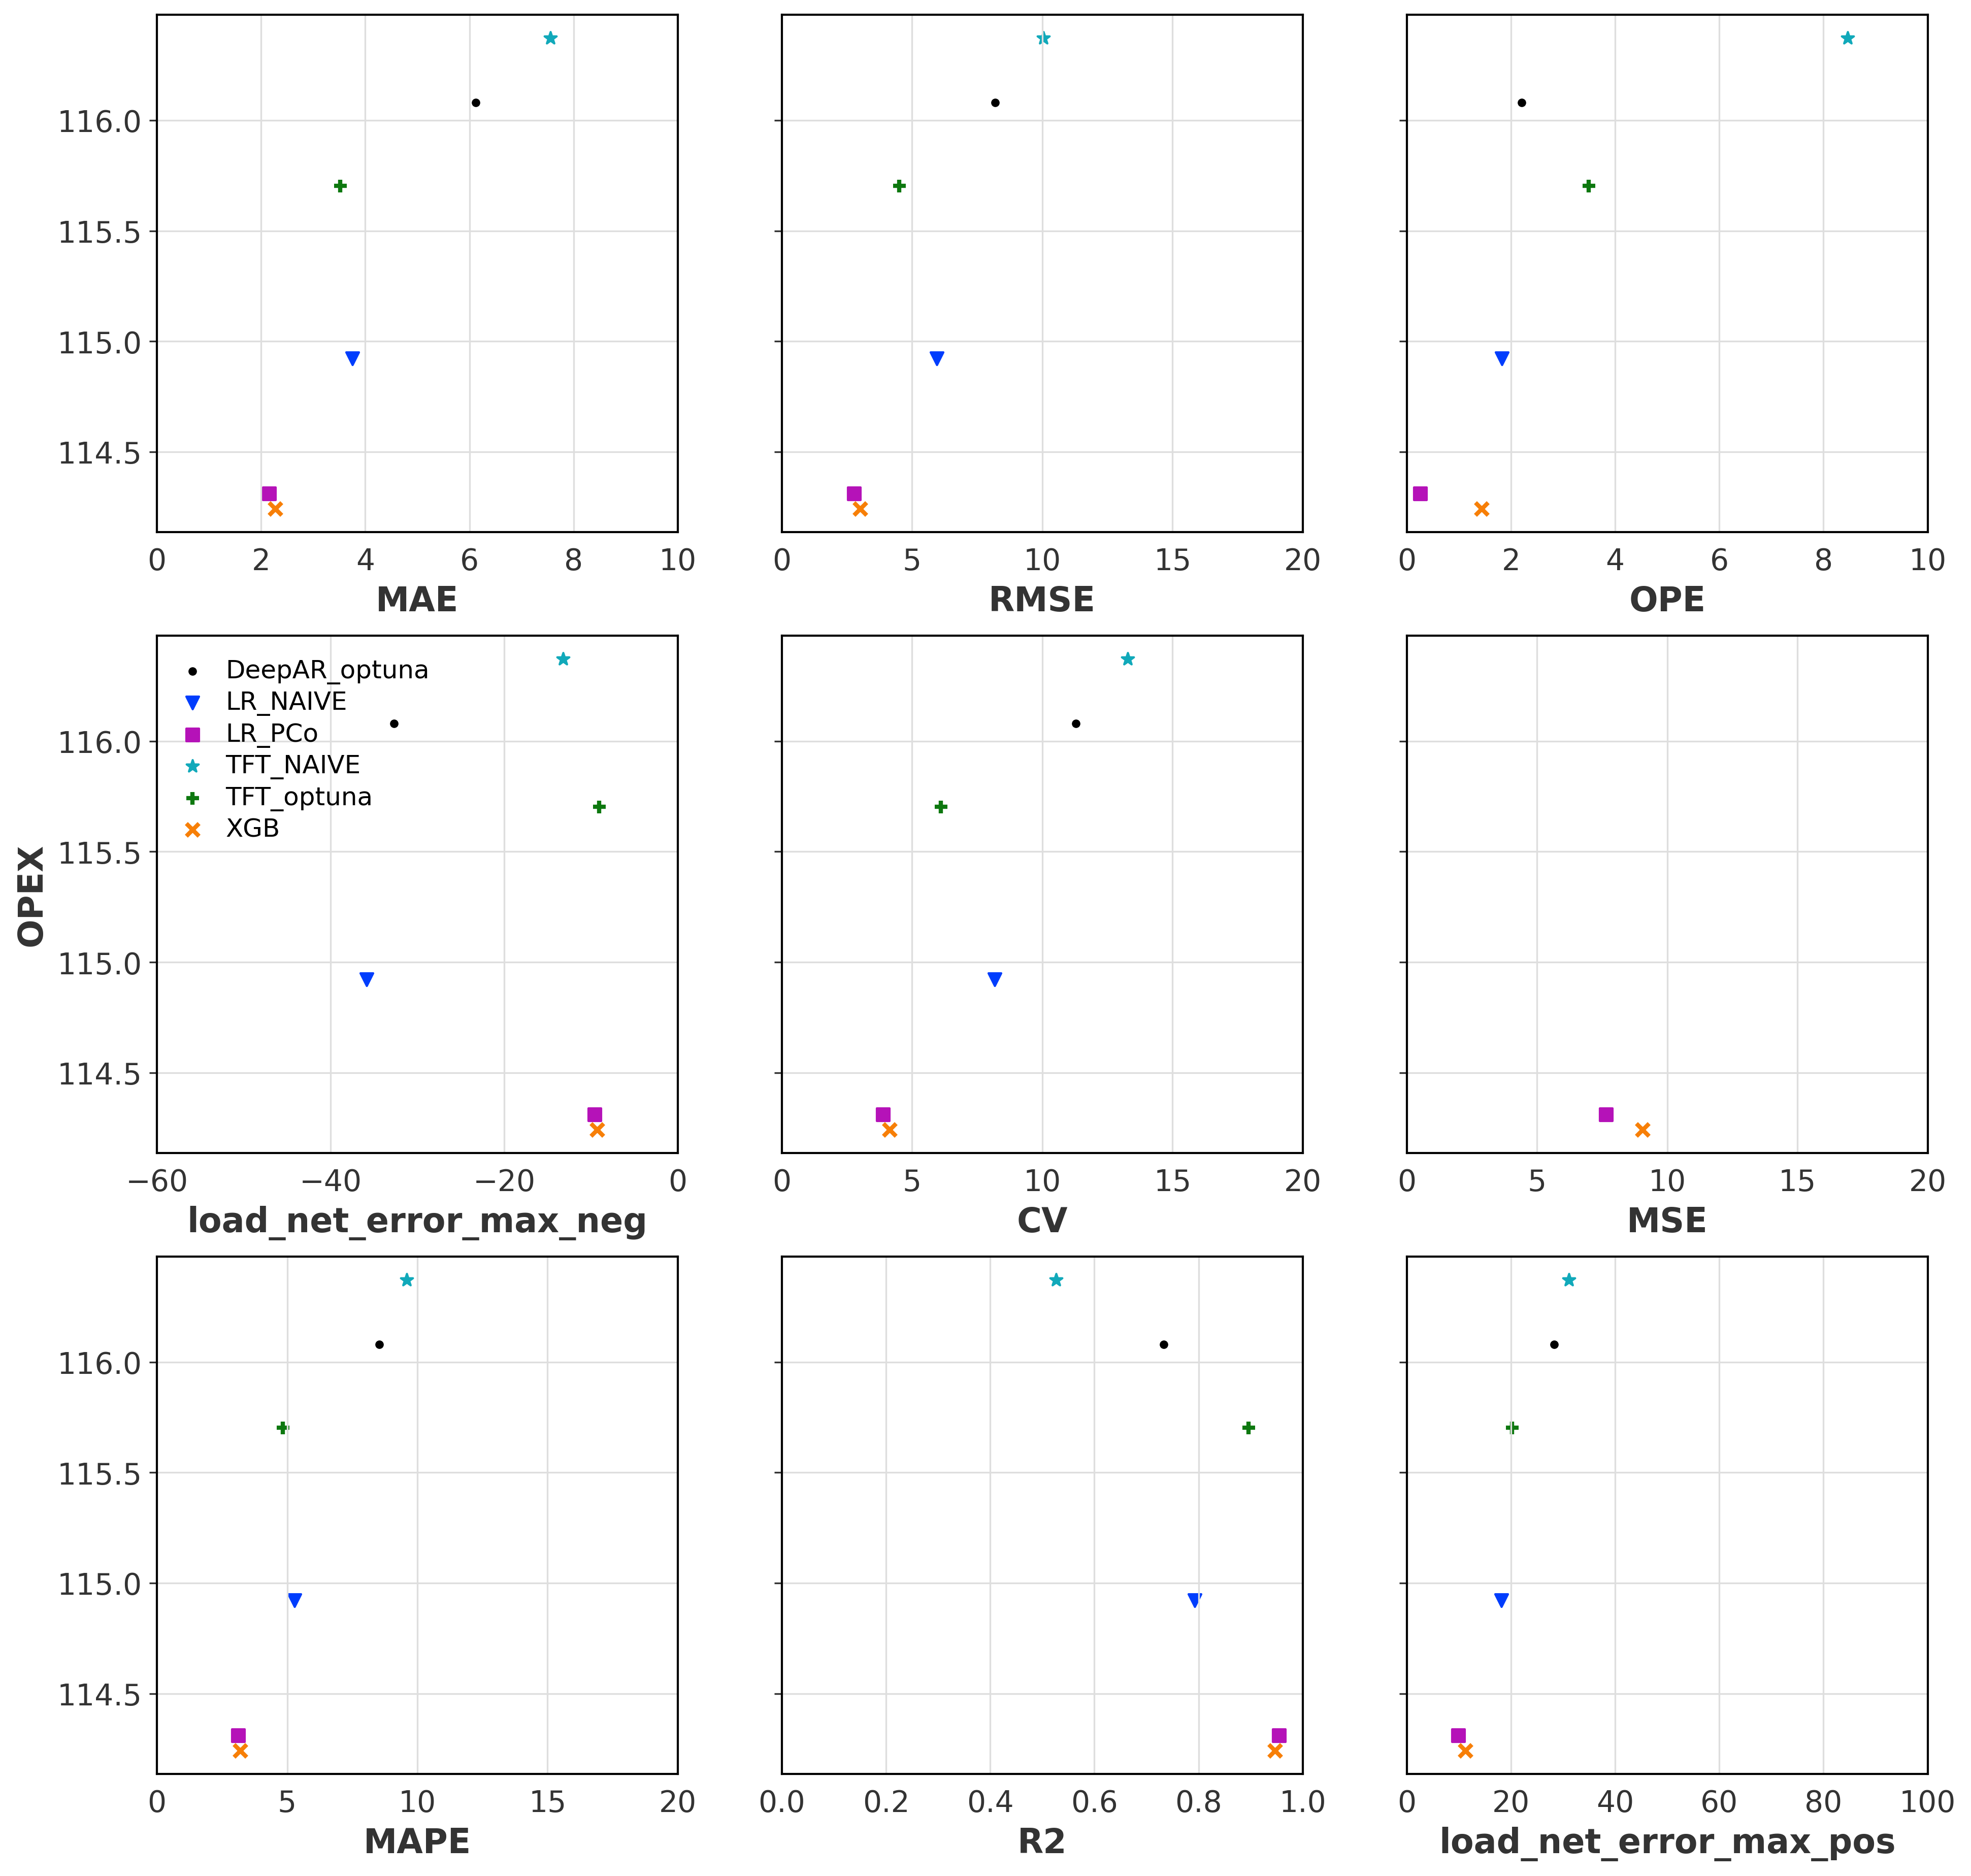

In [212]:
import matplotlib.pyplot as plt
#import numpy as np
#import matplotlib.gridspec as gridspec

'''fig = plt.figure(figsize=(18, 18))  # 创建画布
grid = gridspec.GridSpec(3, 3,width_ratios=[1,1,1],height_ratios=[1,1,1])  
grid.update(wspace =0.16, hspace = 0.18)'''

fig,axs=plt.subplots(3,3,figsize=(15,15),sharex=False,sharey=True)


method_dic=[
    "DeepAR_optuna",
    "LR_NAIVE",
    "LR_PCo",
    "TFT_NAIVE",
    "TFT_optuna",
    "XGB"
]

marker_dic={
    "DeepAR_optuna":'.',
    "LR_NAIVE":'v',
    "LR_PCo":'s',
    "TFT_NAIVE":'*',
    "TFT_optuna":'+',
    "XGB":'x',
    'load_net_error_max_neg':'o',
    'load_net_error_max_pos':'o',
}
xlimit={
    'CV':[0,20],
    'MAE':[0,10],
    'MAPE':[0,20],
    'OPE':[0,10],
    'RMSE':[0,20],
    'MSE':[0,20],
    'MARRE':[0,15],
    'R2':[0,1],
    'SMAPE':[0,15],
    'load_net_error_max_neg':[-60,0],
    'load_net_error_max_pos':[0,100],
}

metrics_keys={
    'CV',
    'MAE',
    'MAPE',
    'OPE',
    'RMSE',
    'MSE',
    #'MARRE',
    'R2',
    #'SMAPE',
    'load_net_error_max_neg',
    'load_net_error_max_pos',
}

total_df_0dc=total_df[(total_df.price_dc==0) & (total_df.month_of_year==6)]
total_df_dc=total_df[(total_df.price_dc==0.6) & (total_df.month_of_year==6)]

'''total_df_0dc=total_df[(total_df.price_dc==0) ]
total_df_dc=total_df[(total_df.price_dc==0.6) ]'''

df_to_plot=total_df_0dc
key_to_plot='OPEX'
i,j=0,0
for metric in metrics_keys:
    ax=axs[i,j] # 第二行，第3列

    for method in method_dic:
        X=df_to_plot[df_to_plot.pred_method==method][metric]
        Y=df_to_plot[df_to_plot.pred_method==method][key_to_plot]
        ax.scatter(X,Y,label=method,marker=marker_dic[method])
        ax.set_xlim(xlimit[metric])
    
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.set_xlabel(metric)
    if i==1 and j==0:
        ax.set_ylabel(key_to_plot)
        ax.legend()
    if i<2:
        i+=1
    else:
        i=0
        j+=1
        
#plt.suptitle(0.5,0.85,"Metrics and relative_OPEX (dc=0)",)

KeyError: ''

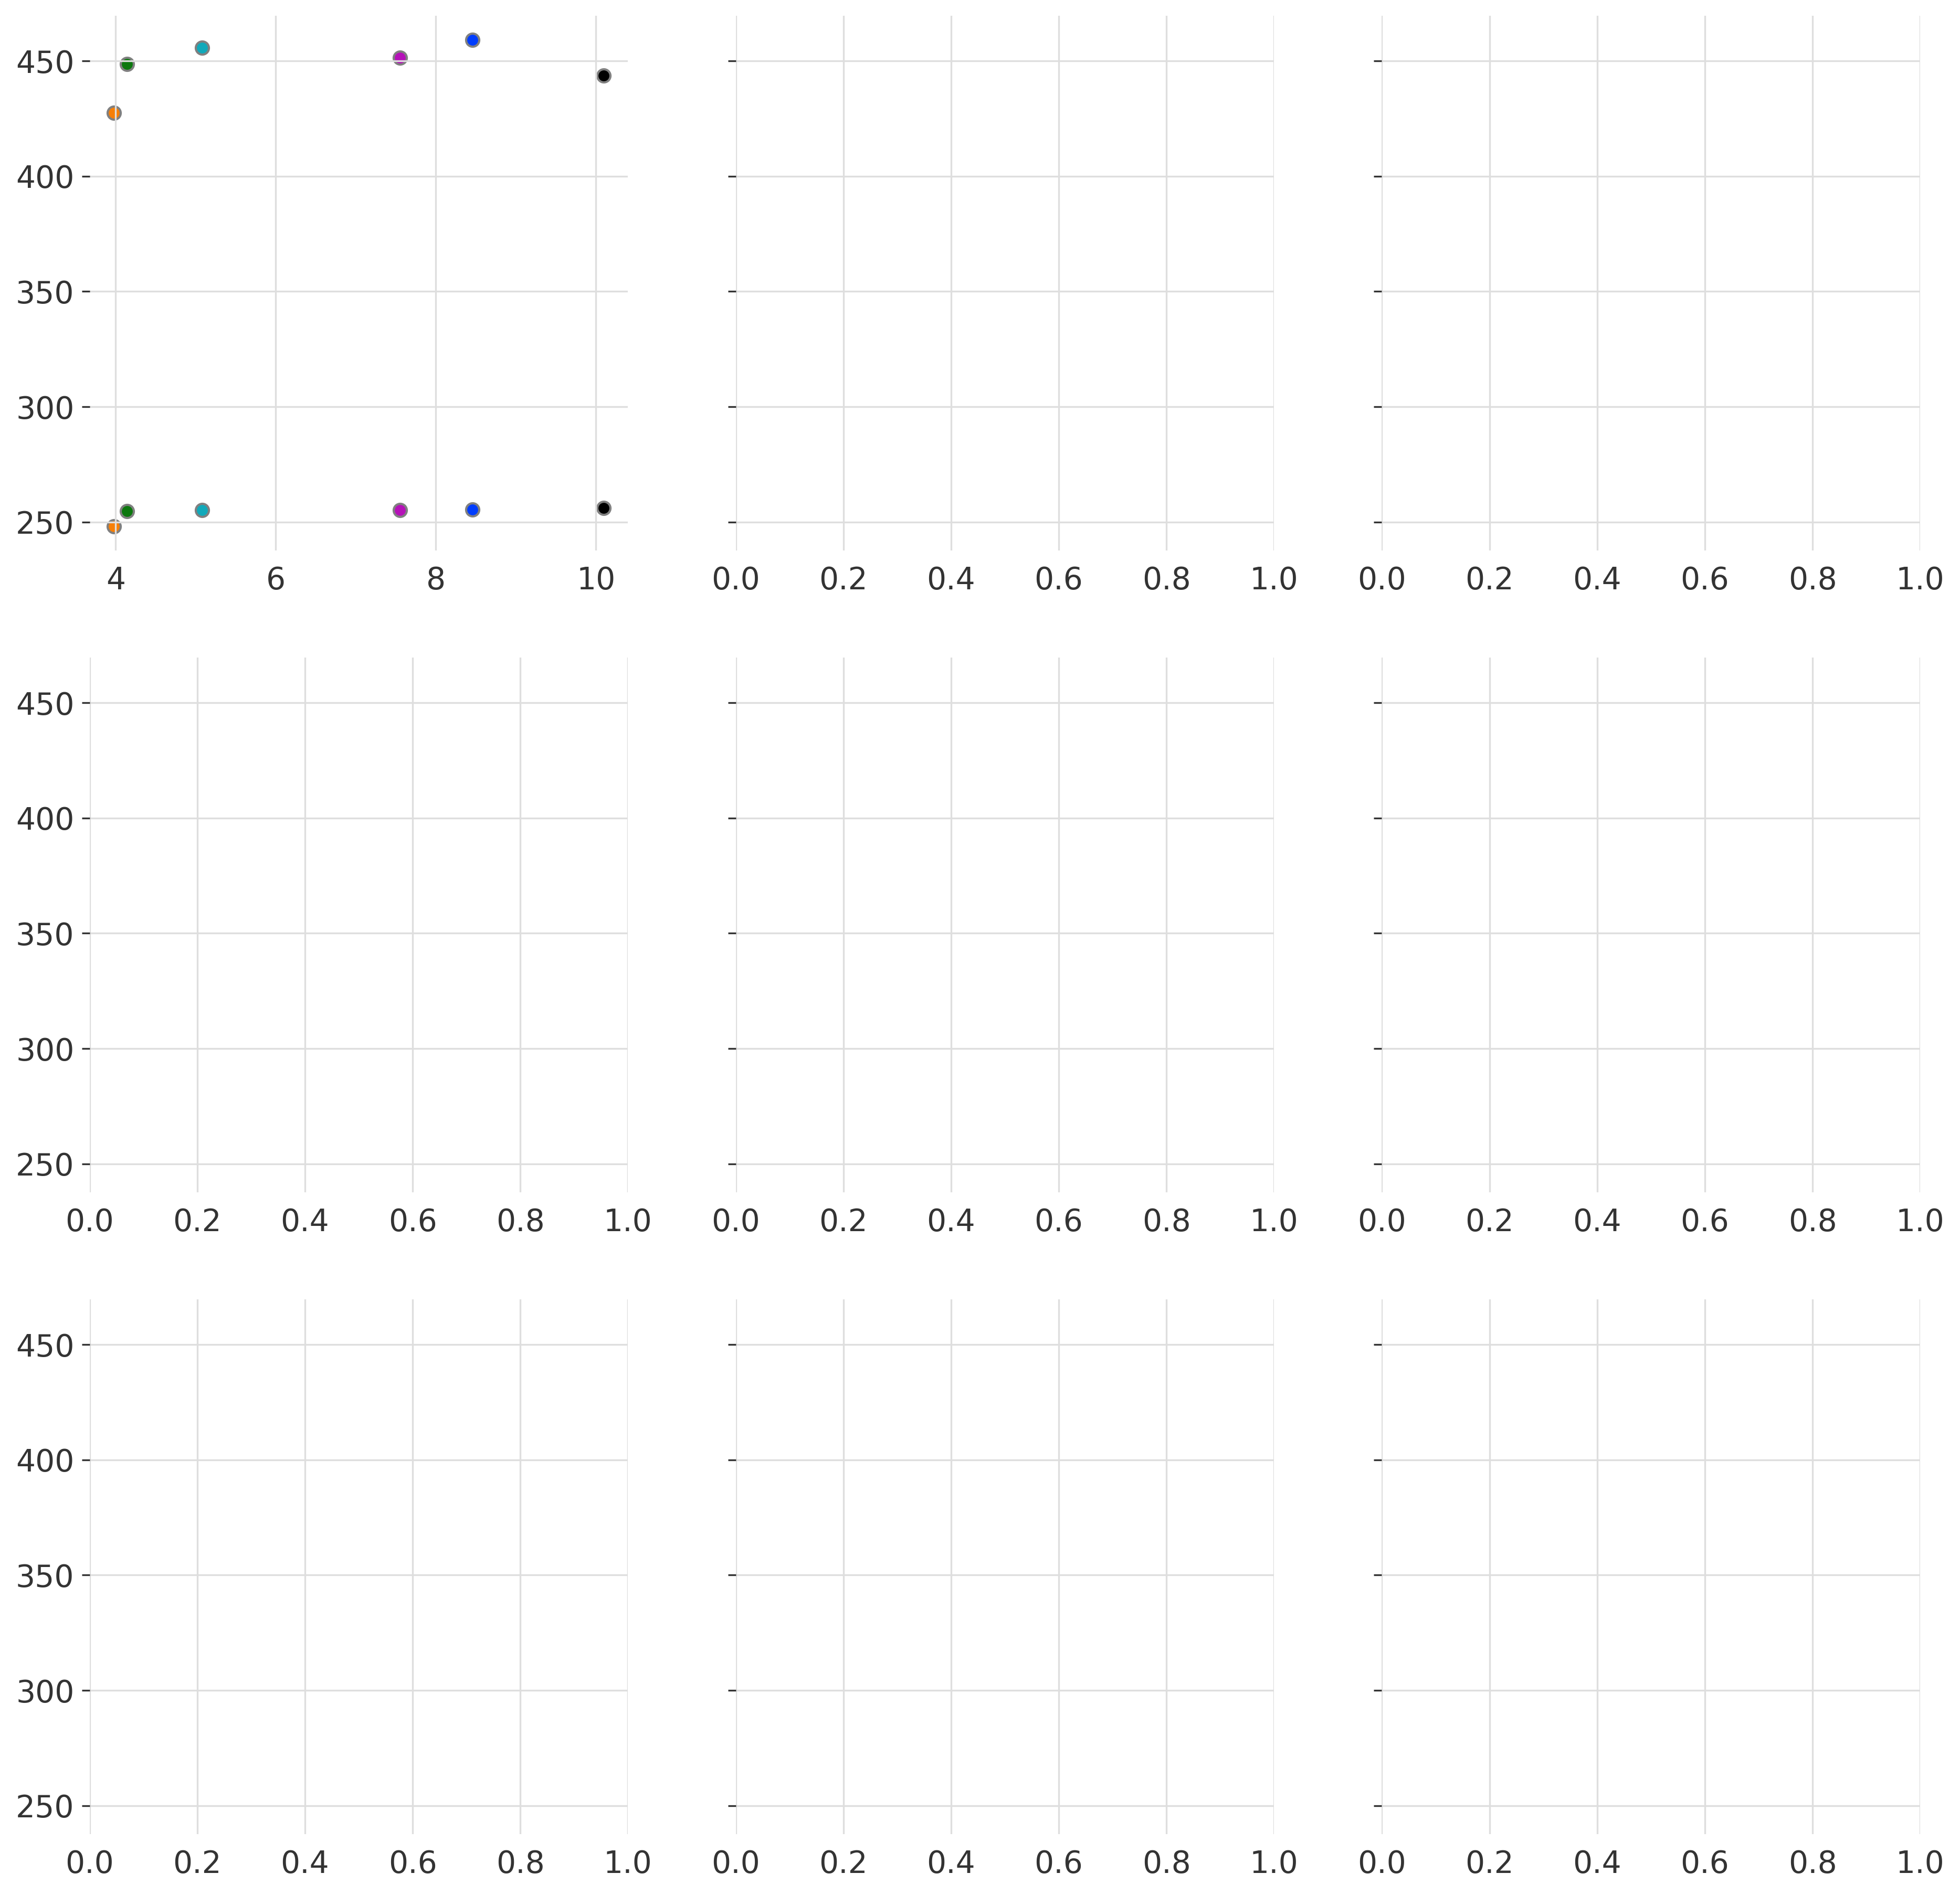

In [198]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharex=False, sharey=True)

method_dic = [
    "DeepAR_optuna",
    "LR_NAIVE",
    "LR_PCo",
    "TFT_NAIVE",
    "TFT_optuna",
    "XGB"
]

total_df_0dc = total_df[(total_df.price_dc == 0) & (total_df.month_of_year == 5)]
total_df_dc = total_df[(total_df.price_dc == 0.6) & (total_df.month_of_year == 5)]

df_to_plot=total_df_dc
key_to_plot = 'OPEX'
i, j = 0, 0
for metric in metrics_method_dic.keys():
    ax = axs[i, j]  # Get the current Axes object
    if i < 2:
        i += 1
    else:
        i = 0
        j += 1
    for method in method_dic:
        X = df_to_plot[df_to_plot.pred_method == method][metric]
        Y = df_to_plot[df_to_plot.pred_method == method][key_to_plot]
        ax.scatter(X, Y, label=method, edgecolors=['gray'])
    
    # Show the spines
    ax.spines[''].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
    # Add other plot customizations
    ax.set_xlabel(metric)
    ax.set_ylabel(key_to_plot)
    ax.legend()

plt.show()
